# Spotify genres challenge

## Table of contents

## Introduction

### Faire quelques sous parties selon ce qu'on dit dans l'intro, ne pas utiliser nos données

### Definition of the problem: ...

## Data Exploration

### Prerequisites

In [117]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from skmultilearn.model_selection import iterative_train_test_split

from problem import EMDScore

### Download the data

In order to locally download the data for the challenge you need to download it using these 4 links:
- https://lufi.rezel.net/r/9e1y73tnKZ#veGDCVU419FQL6c7oZfz2f7HAr7RoxddPlQZcFyJVdI=
- https://lufi.rezel.net/r/geTCfJU5Fc#0rK1Yrmh8mSzUvdTWA3pj0Ec28lgr4qV4ZrLsXKzWt0=
- https://lufi.rezel.net/r/fsAUYoz7KF#rg/+niesg9svKzozEJ8JBvSy3yDpKHU+t3djv54/UEk=
- https://lufi.rezel.net/r/5UuqDr45Wo#lCF2mQHDrykyvBdW2NU2a95MqggzWJ/l+zNMGQyaKmc=

Once it is done put them in the `/data` folder.

If it is unavailable run the entire `/data/data_constructor.ipynb` notebook and then the `split_dataset.py` Python script. Be patient, this may take more than one hour since the dataset size is approximatively 2 GB. Once you have done this pay only attention to the files `/data/X_train.csv`, `/data/y_train.csv`, `/data/X_test.csv` and `/data/y_test.csv`

### Load the data

To obtain the data for this challenge we have used the Python library `spotipy` using the Spotify API that is provided for free for anyone having a Spotify account. We have selected all the tracks of 7 playlists of various genres of the website http://everynoise.com/ and collected our features among the ones provided by Spotify through the `audio_analysis` and the `audio_features`.

The genres of each track have been collected thanks to the genres of the album when available and the genres of the artist if not. Then we have considered only the 25 most common genres to ensure that a sufficient number of tracks belong to each genre. For each track its genres are provided as a list so to retrieve the labels of each track as binary lists of size 25 (each cell containing 1 if it belongs to the genre represented by index, 0 if not) we have used the `MultiLabelBinarizer` class provided by `scikit-learn`.

As a result we have obtained 6071 tracks with their features and their uri (each track is identified by Spotify thanks to a unique uri) which we have removed from the dataset to "anonymize" the tracks. We have separated this dataset using the function `iterative_train_test_split` provided by `scikit-multilearn`, which is suited for multi-label classification problems. Indeed, it has the particularity to split the dataset using iterative stratification so it tries to keep the genres distribution when separating train an test. We obtained 3 datasets: 2846 tracks for the local train dataset (`/data/X_train.csv` and `/data/y_train.csv`), 1221 for the local test dataset (`/data/X_test.csv` and `/data/y_test.csv`) and 2004 for the online test dataset (the one that is used by the server to compute leaderboard scores).

(If you want practical details please look at the `data_constructor.ipynb` Jupyter notebook and the `split_dataset.py` Python script)

In [2]:
X_df = pd.read_csv('data/X_train.csv', sep=';').drop(['Unnamed: 0'], axis=1)
y_df = pd.read_csv('data/y_train.csv', sep=';').drop(['Unnamed: 0'], axis=1)

In [4]:
X_df.head(3)

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mode,duration_ms,time_signature,key,sections,segments,loudness
0,0.259,0.437,0.0386,0.1020,0.000001,0.1060,0.0951,180.042,0,239000,4,11,"[{'start': 0.0, 'duration': 10.22381, 'confide...","[{'start': 0.0, 'duration': 0.20308, 'confiden...",-6.589
1,0.664,0.708,0.0474,0.0337,0.000000,0.0841,0.7420,103.070,1,174800,4,8,"[{'start': 0.0, 'duration': 5.27332, 'confiden...","[{'start': 0.0, 'duration': 0.19188, 'confiden...",-4.154
2,0.697,0.683,0.1170,0.0372,0.000000,0.1370,0.6030,96.133,0,186987,4,1,"[{'start': 0.0, 'duration': 14.72376, 'confide...","[{'start': 0.0, 'duration': 0.20313, 'confiden...",-2.881


In [5]:
y_df.head(3)

,rock,pop,latin,edm,rap,dance pop,pop dance,electro house,alternative metal,hip hop,...,post-teen pop,album rock,latin pop,southern hip hop,hard rock,gangster rap,electropop,big room,classical,reggaeton
0,0,1,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### The features

In [6]:
X_df.columns

Index(['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'mode',
       'duration_ms', 'time_signature', 'key', 'sections', 'segments',
       'loudness'],
      dtype='object')

We have 15 features for this challenges: 13 being static features and 2 being sequential features.

#### The static features

We have 13 static features provided by Spotify `audio_features`:
1. **danceability** (float): Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
2. **energy** (float): Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
3. **speechiness** (float): Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
4. **acousticness** (float): A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
5. **instrumentalness** (float): Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
6. **liveness** (float): Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
7. **valence** (float): A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
8. **tempo** (float): The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
9. **mode** (int): Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
10. **duration_ms** (int): The duration of the track in milliseconds.
11. **time_signature** (int): 	An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
12. **key** (int): The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
13. **loudness** (float): The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

(descriptions provided at https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

#### The sequential features

We have 2 sequential features provided by Spotify `audio_analysis`:
1. **sections** (an array of section objects): Sections are defined by large variations in rhythm or timbre, e.g. chorus, verse, bridge, guitar solo, etc. Each section contains its own descriptions of tempo, key, mode, time_signature, and loudness. Each section object is composed of 12 features:
    - *start* (float): The starting point (in seconds) of the section.
    - *duration* (float): The duration (in seconds) of the section.
    - *confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the section’s “designation”.
    - *loudness* (float): The overall loudness of the section in decibels (dB). Loudness values are useful for comparing relative loudness of sections within tracks.
    - *tempo* (float): The overall estimated tempo of the section in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
    - *tempo_confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the tempo. Some tracks contain tempo changes or sounds which don’t contain tempo (like pure speech) which would correspond to a low value in this field.
    - *key* (int): The estimated overall key of the section. The values in this field ranging from 0 to 11 mapping to pitches using standard Pitch Class notation (E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on). If no key was detected, the value is -1.
    - *key_confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the key. Songs with many key changes may correspond to low values in this field.
    - *mode* (int):	Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. This field will contain a 0 for “minor”, a 1 for “major”, or a -1 for no result. Note that the major key (e.g. C major) could more likely be confused with the minor key at 3 semitones lower (e.g. A minor) as both keys carry the same pitches.
    - *mode_confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the mode.
    - *time_signature* (int): An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of “3/4”, to “7/4”.
    - *time_signature_confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the time_signature. Sections with time signature changes may correspond to low values in this field.
    
    
2. **segments** (an array of segment objects): Audio segments attempts to subdivide a song into many segments, with each segment containing a roughly consistent sound throughout its duration. Each segment object is composed of 9 features:
    - *start* (float): The starting point (in seconds) of the segment.
    - *duration* (float): The duration (in seconds) of the segment.
    - *confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the segmentation. Segments of the song which are difficult to logically segment (e.g: noise) may correspond to low values in this field.
    - *loudness_start* (float): The onset loudness of the segment in decibels (dB). Combined with loudness_max and loudness_max_time, these components can be used to describe the “attack” of the segment.
    - *loudness_max* (float): The peak loudness of the segment in decibels (dB). Combined with loudness_start and loudness_max_time, these components can be used to describe the “attack” of the segment.
    - *loudness_max_time* (float): The segment-relative offset of the segment peak loudness in seconds. Combined with loudness_start and loudness_max, these components can be used to describe the “attack” of the segment.
    - *loudness_end* (float): The offset loudness of the segment in decibels (dB). This value should be equivalent to the loudness_start of the following segment.
    - *pitches* (array of floats): A “chroma” vector representing the pitch content of the segment, corresponding to the 12 pitch classes C, C#, D to B, with values ranging from 0 to 1 that describe the relative dominance of every pitch in the chromatic scale. More details about how to interpret this vector can be found below.
    - *timbre* (array of floats): Timbre is the quality of a musical note or sound that distinguishes different types of musical instruments, or voices. Timbre vectors are best used in comparison with each other. More details about how to interpret this vector can be found on the below.

(descriptions provided at https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/)

In [3]:
X_df['sections'] = X_df['sections'].apply(ast.literal_eval)
X_df['segments'] = X_df['segments'].apply(ast.literal_eval)

To begin with we can print several statistic indicators concerning the length the `sections` feature of each track.

In [19]:
X_df['sections'].apply(lambda x: len(x)).describe()

count    2846.000000
mean       10.636683
std         3.809263
min         4.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        49.000000
Name: sections, dtype: float64

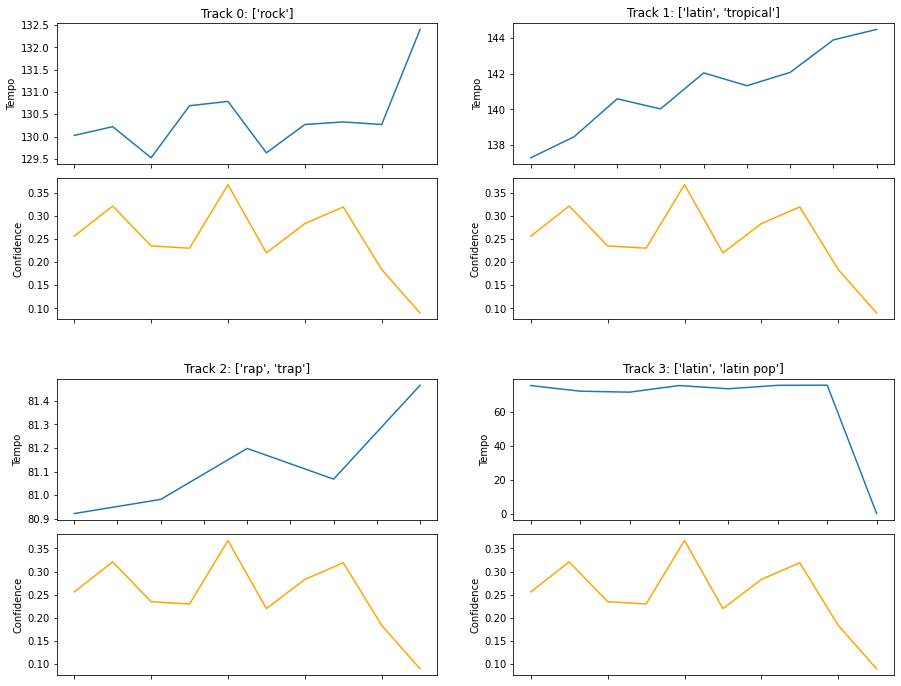

In [136]:
tracks = np.random.choice(range(0, len(X_df)), size=4, replace=False)
tempos = [[x['tempo'] for x in X_df['sections'][i]] for i in tracks]
tempos_confidence = [[x['tempo_confidence'] for x in X_df['sections'][0]] for i in tracks]
genres = [y_df.columns[np.array(y_df.iloc[i].tolist()) > 0].tolist() for i in tracks]

fig = plt.figure(figsize=(15, 12))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    ax1 = plt.Subplot(fig, inner[0])
    ax1.plot(tempos[i])
    ax1.set_ylabel("Tempo")
    ax1.axes.xaxis.set_ticklabels([])
    fig.add_subplot(ax1)
    ax1.set_title("Track %d: " % i + str(genres[i]))
    
    ax2 = plt.Subplot(fig, inner[1])
    ax2.plot(tempos_confidence[i], 'orange')
    ax2.set_ylabel("Confidence")
    ax2.axes.xaxis.set_ticklabels([])
    fig.add_subplot(ax2)

plt.show()

### The genres

Among the millions of artists that are present in the Spotify dataset their a huge number of genres, the website http://everynoise.com/ provides a list of them and it seems that they are more than 5000. Considering all the existing genres it would have been impossible to perform a multi-label classification task with a reasonnable dataset size. As a result, we have only considered the 25 genres that are the most present in our dataset and we have adapted our metric to suit these genres.

The 25 genres that we have considered are:
- rock
- pop
- latin
- edm
- rap
- dance pop
- pop dance
- electro house
- alternative metal
- hip hop
- pop rap
- tropical
- trap
- nu metal
- classic rock
- post-teen pop
- album rock
- latin pop
- southern hip hop
- hard rock
- gangster rap
- electropop
- big room
- classical
- reggaeton

As you can see they are quite various and they almost have a quite distinct identity, e.g. we don't have genres that are all similar.

First we can see if our genres are uniformly distributed or if our dataset is imbalanced.

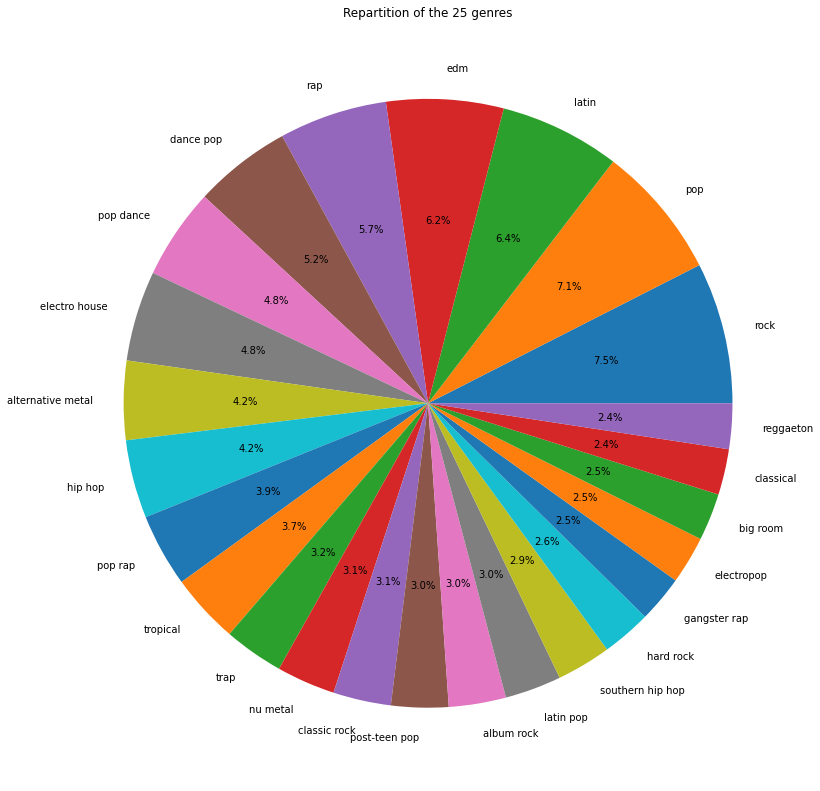

In [7]:
y_df.sum().plot(figsize=(14,14), kind='pie', title='Repartition of the 25 genres', ylabel='', autopct='%1.1f%%')
plt.show()

It seems that the genres are quite uniformly distributed since their proportion in the dataset varies from 2.4% to 7.5%. For a multi-label classification problem we can be quite satisfied with this repartition.

Since we have a multi-label classification problem it can be interesting to see the average number of genres for a track of the dataset.

In [16]:
print("In our dataset the average number of genres for each track is %.3f." %(y_df.sum(axis=1).mean()))

In our dataset the average number of genres for each track is 2.662.


### Performance metric

In [9]:
metric = np.load('metric/metric_genres_considered.npy')

genre_index = joblib.load('metric/genre_index.dict')
index_genre = joblib.load('metric/index_genre.dict')

## Submission

In [10]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X_df.to_numpy(), y_df.to_numpy(), test_size=0.3)
X_train, y_train = pd.DataFrame(X_train, columns=X_df.columns), pd.DataFrame(y_train, columns=y_df.columns)
X_test, y_test = pd.DataFrame(X_test, columns=X_df.columns), pd.DataFrame(y_test, columns=y_df.columns)

In [11]:
cols = [
    'danceability',
    'energy',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo', 
    'mode', 
    'duration_ms', 
    'time_signature', 
    'key',
    'loudness'
]

transformer = make_column_transformer(
    ('passthrough', cols)
)

pipe = make_pipeline(
    transformer,
    DecisionTreeClassifier()
)


def get_estimator():
    return pipe

In [12]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['danceability', 'energy',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'mode',
                                                   'duration_ms',
                                                   'time_signature', 'key',
                                                   'loudness'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [13]:
y_pred = pipe.predict(X_test)
jac_score = jaccard_score(y_test.values, y_pred, average='samples')
emd_score = EMDScore()(y_test.values, y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
jac_score, emd_score

(0.3508410468012341, 0.3954795263942779)